In [1]:
using Revise
using TransportBasedInference
using HierarchicalDA
using LinearAlgebra
using OrdinaryDiffEq
using Trixi
using FFTW
using DifferentialEquations
using Distributions
using Statistics
using SparseArrays
using LinearMaps

In [2]:
using CairoMakie
using LaTeXStrings
# using Plots

In [3]:
polydeg = 3
Ncells = 100

Nx = (polydeg+1)*Ncells
Δ = 20
Ny = ceil(Int64, Nx/Δ)

# Define Trixi system for linear advection equation
sys_lin = setup_linear_advection(polydeg, Ncells);

xgrid = vec(sys_lin.mesh.md.xq);

Define polynomial annihilator operator

In [288]:
order_PA = 1

Ns = Nx - 2*ceil(Int64, order_PA/2)

PA = PolyAnnil(xgrid, order_PA; istruncated = true)

@assert size(PA.P) == (Ns, Nx)

S = LinearMaps.FunctionMap{Float64,true}((s,x)->mul!(s, PA.P, x), (x,s)->mul!(x, PA.P', s),
Ns, Nx; issymmetric=false, isposdef=false)

xs = xgrid[ceil(Int64, order_PA/2)+1:end-ceil(Int64, order_PA/2)]

398-element Vector{Float64}:
 -0.9933998104358487
 -0.9866001895641519
 -0.9813886368840595
 -0.9786113631159403
 -0.9733998104358488
 -0.9666001895641518
 -0.9613886368840595
 -0.9586113631159403
 -0.9533998104358486
 -0.9466001895641517
 -0.9413886368840595
 -0.9386113631159403
 -0.9333998104358486
  ⋮
  0.9386113631159406
  0.9413886368840593
  0.9466001895641516
  0.9533998104358488
  0.9586113631159405
  0.9613886368840594
  0.9666001895641515
  0.973399810435849
  0.9786113631159405
  0.9813886368840595
  0.9866001895641516
  0.9933998104358489

In [289]:
xs[1:3]-xs[2:4]

3-element Vector{Float64}:
 -0.006799620871696832
 -0.005211552680092324
 -0.002777273768119204

In [290]:
PA.P[34:40,34:40]

7×7 SparseMatrixCSC{Float64, Int64} with 13 stored entries:
 -1.0   1.0    ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅   -1.0   1.0    ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅   -1.0   1.0    ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅   -1.0   1.0    ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅   -1.0   1.0    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -1.0   1.0
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -1.0

In [100]:
Matrix(PA.P)[1:10, 1:10]

10×10 Matrix{Float64}:
 -1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0  -1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0   1.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0  -1.0   1.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0  -1.0   1.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0  -1.0   1.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0  -1.0   1.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  -1.0   1.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  -1.0

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [5]:
Δtdyn = 0.01
Δtobs = 0.01

0.01

Define the time span of interest

In [6]:
t0 = 0.0
Tf = 200
Tspin = 100
tf = t0 + Tf*Δtobs

2.0

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [7]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 400
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


In [192]:
σx_true = 1e-6#0.001#Δtobs*1.0
σx = 5e-2#0.01#copy(σx_true)
@show σx


σy = 0.2

ϵx_true = AdditiveInflation(Nx, zeros(Nx), σx_true)
ϵx = AdditiveInflation(Nx, zeros(Nx), σx)

ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

σx = 0.05


AdditiveInflation(20, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.04000000000000001 0.0 … 0.0 0.0; 0.0 0.04000000000000001 … 0.0 0.0; … ; 0.0 0.0 … 0.04000000000000001 0.0; 0.0 0.0 … 0.0 0.04000000000000001], [0.2 0.0 … 0.0 0.0; 0.0 0.2 … 0.0 0.0; … ; 0.0 0.0 … 0.2 0.0; 0.0 0.0 … 0.0 0.2])

Setup system for linear advection equation

In [193]:
h(x, t) = x[1:Δ:end]
H = LinearMap(sparse(Matrix(1.0*I, Nx, Nx)[1:Δ:end,:]))
F = StateSpace(x->x, h)

StateSpace(var"#73#74"(), TransportBasedInference.var"#27#28"(), h)

Define ObsConstraintSystem

In [194]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx_true, ϵy, π0, 0, 0, 0, F);

In [195]:
# Define function class for the initial condition
αk = 0.7
f0 = SmoothPeriodic(xgrid, αk; L = 2.0)

SmoothPeriodic(400, 1, 2.0, 0.7, ComplexF64[0.44384033250761046 - 0.21552291332278076im, 0.05599136504680808 - 0.14871829665451008im, -0.10549503393221515 - 0.12093156968627815im, -0.1425639685465759 + 0.11938181919405047im, -0.23681412302675656 - 0.06743054310589806im, -0.15206338873874545 - 0.11262068973559851im, 0.14550434073075594 + 0.27887254216881274im, 0.050578765664465446 - 0.15438267946489767im, 0.03557937774262328 - 0.05249471213568364im, 0.012645975320488627 + 0.05428678652768934im  …  9.095124828899904e-16 - 6.8898857270160796e-15im, -5.96245754357716e-15 + 6.064022096019116e-16im, 1.1712687738739044e-15 - 2.669056975913211e-15im, 5.204153242867062e-15 + 7.793943332153911e-15im, -8.998700626461153e-16 - 5.356531036258385e-15im, -5.963133331251718e-15 + 2.3826320946837857e-15im, 7.114070424435282e-16 - 5.1313920003968716e-15im, -5.7834589998741e-15 - 3.503218984163379e-15im, -3.5239955087305257e-15 + 2.775785572817839e-15im, -3.914202922894725e-17 + 3.7451511570062716e-15im]

In [196]:
# x0 = vec(1/2 .+ 0.5*sin.(3*π*xgrid));
# x0 = vec(step_function.(xgrid));
x0 = vec(glaubitz_jump1.(xgrid))

400-element Vector{Float64}:
 1.2837570664342308e-5
 0.0002885030395511878
 0.001181046518812909
 0.0022664411702911975
 0.0029849424506296295
 0.0045924916687874835
 0.007190662526819356
 0.009558864986416392
 0.010952355597418719
 0.013810404492342904
 0.018008672613216186
 0.02157930035824657
 0.023605121374834455
 ⋮
 0.00016763983342251402
 0.00011675242414440194
 6.866181800716436e-5
 4.318347352763034e-5
 3.289388393827379e-5
 1.861402592685824e-5
 7.592752702037424e-6
 3.207557316085359e-6
 1.849232008220736e-6
 5.021535166560661e-7
 2.996424137889468e-8
 5.932915940227563e-11

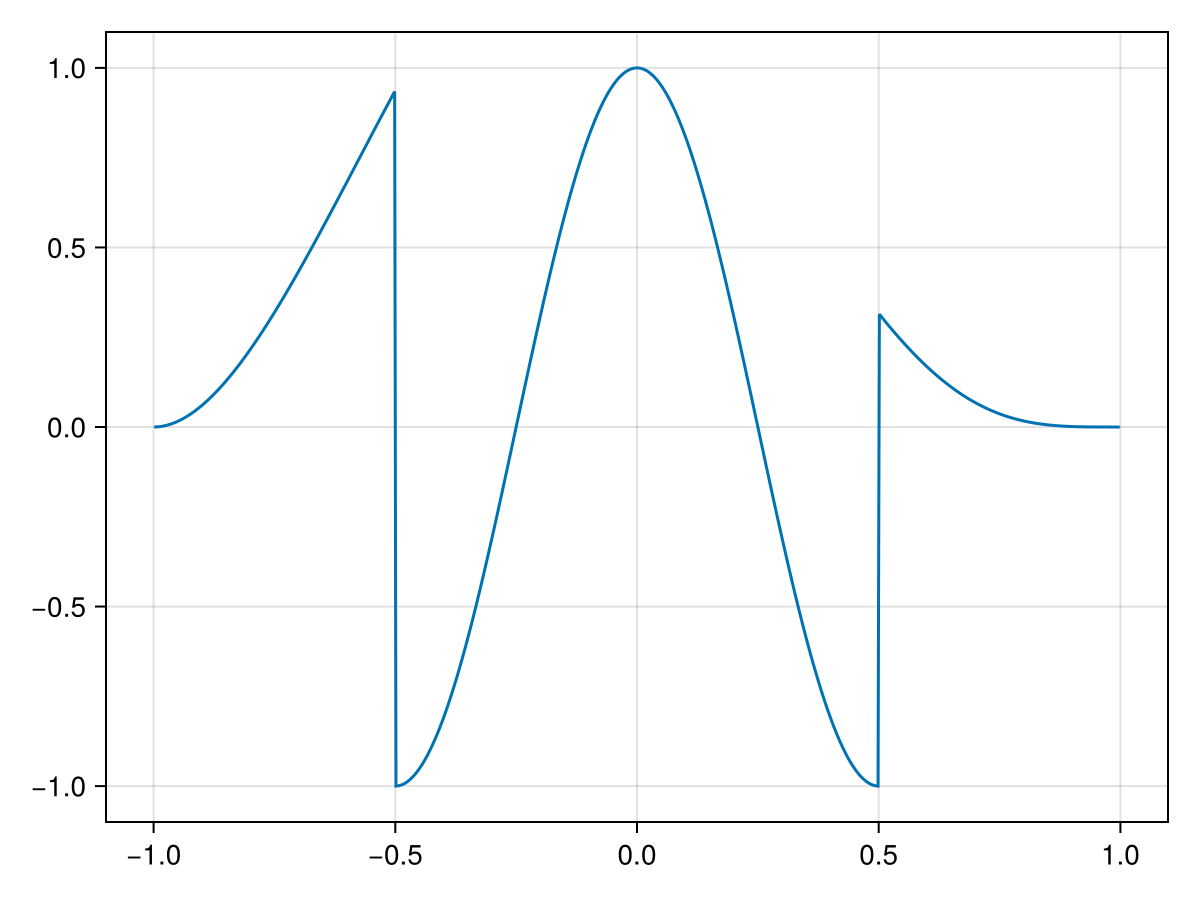

In [296]:
lines(xgrid, x0)

In [198]:
@time data = generate_data_trixi(model, x0, Tf, sys_lin)

  0.046938 seconds (53.67 k allocations: 27.889 MiB, 6.50% compilation time)


SyntheticData([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1  …  1.9100000000000001, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0], 0.01, [1.2837570664342308e-5, 0.0002885030395511878, 0.001181046518812909, 0.0022664411702911975, 0.0029849424506296295, 0.0045924916687874835, 0.007190662526819356, 0.009558864986416392, 0.010952355597418719, 0.013810404492342904  …  6.866181800716436e-5, 4.318347352763034e-5, 3.289388393827379e-5, 1.861402592685824e-5, 7.592752702037424e-6, 3.207557316085359e-6, 1.849232008220736e-6, 5.021535166560661e-7, 2.996424137889468e-8, 5.932915940227563e-11], [7.090277264539264e-6 -2.4457173301756654e-6 … 0.0008943530690553387 6.068112872844751e-5; -1.3895573240944535e-5 9.739452514343128e-6 … 0.0018036816728629057 0.00036025394809047716; … ; 2.4732807952300774e-6 9.96753882822804e-6 … 0.00014776785876012747 -5.3528515466414845e-5; 7.171707024407018e-7 4.898914242233606e-6 … 0.0005536698810385747 -1.4329783298012649e-5], [0.007307627263014563 0

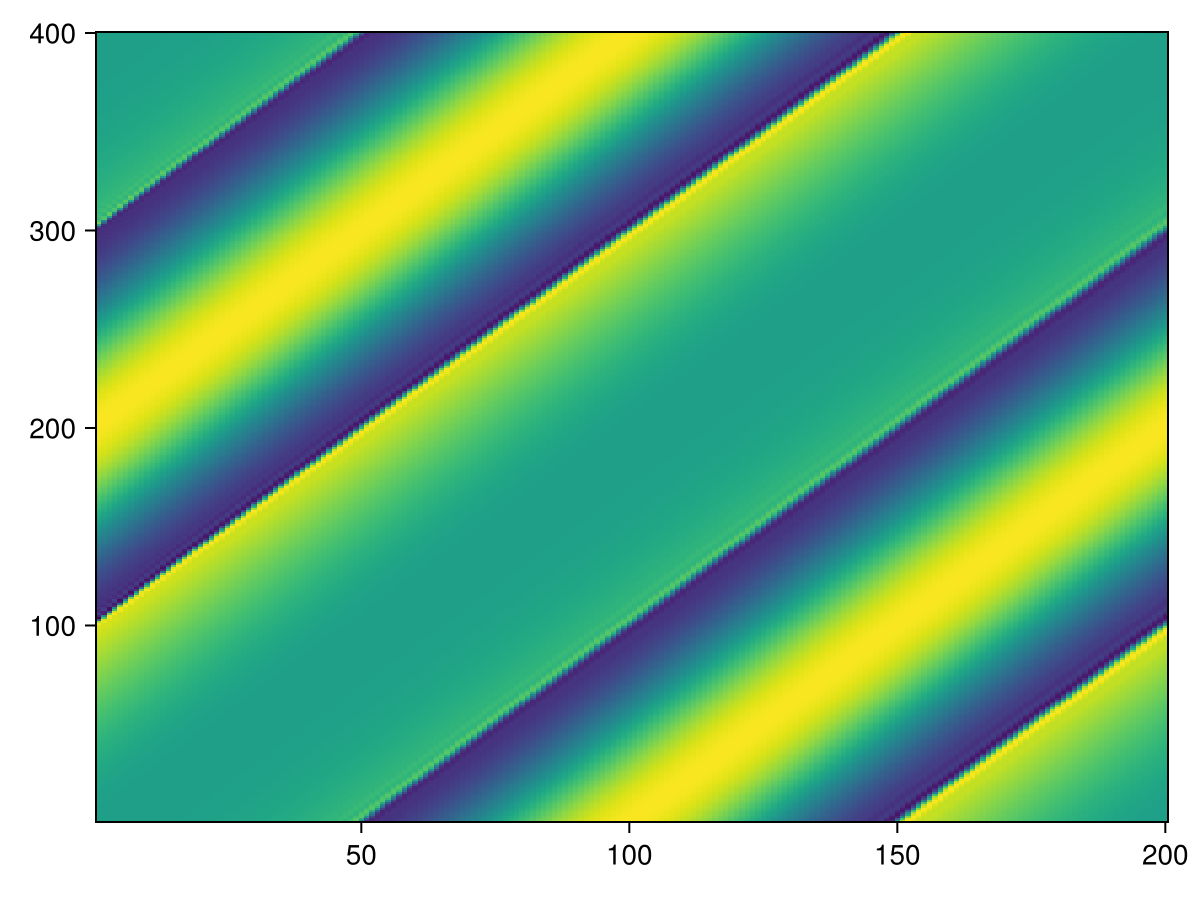

In [199]:
heatmap(data.xt[:, 1:end]')

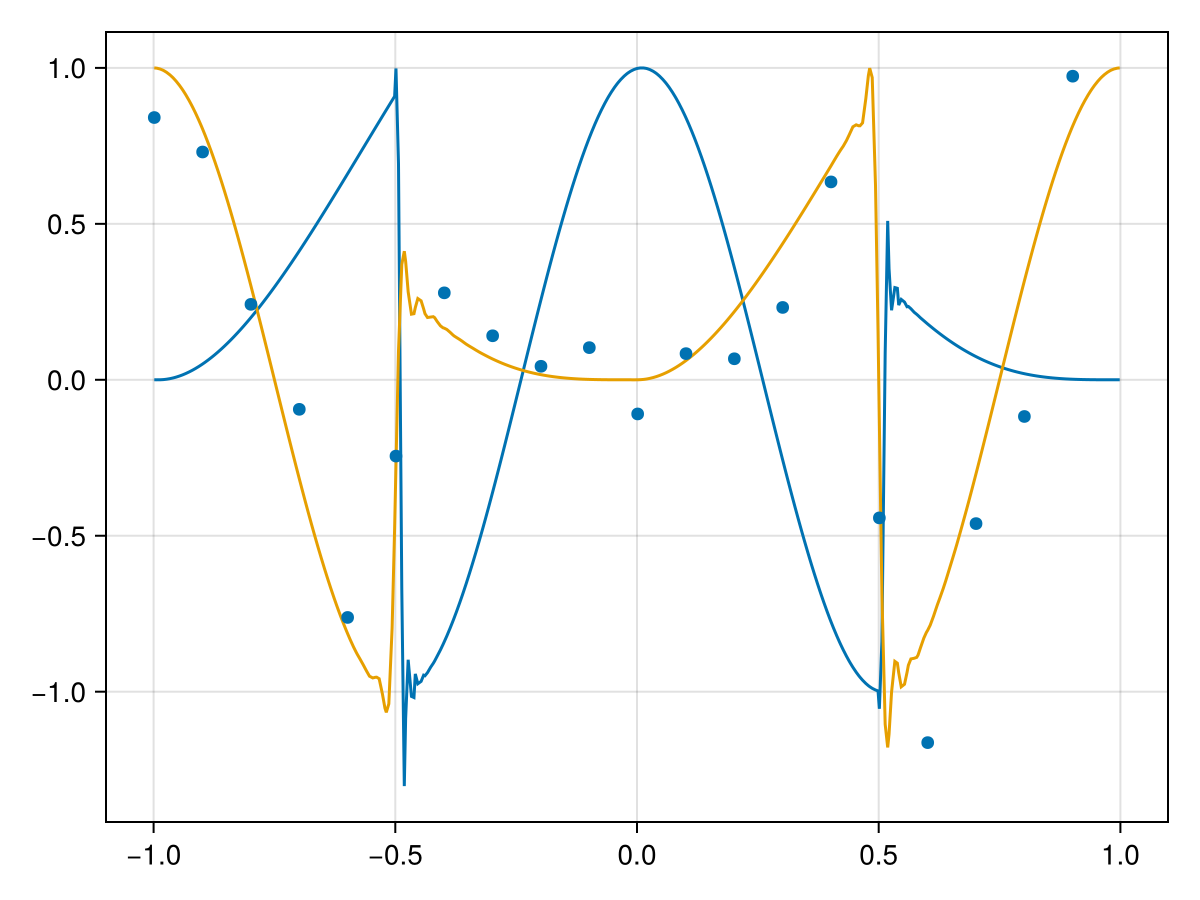

In [200]:
fig = Figure()
ax = Axis(fig[1,1])

lines!(ax, xgrid, data.xt[:,1])
lines!(ax, xgrid, data.xt[:,100])
scatter!(ax, xgrid[1:Δ:end], data.yt[:,100])

fig

In [201]:
norm(data.xt[:,1] .- mean(data.xt[:,1]))

10.883752167868952

In [202]:
norm(data.xt[:,1000] .- mean(data.xt[:,1000]))

LoadError: BoundsError: attempt to access 400×200 Matrix{Float64} at index [1:400, 1000]

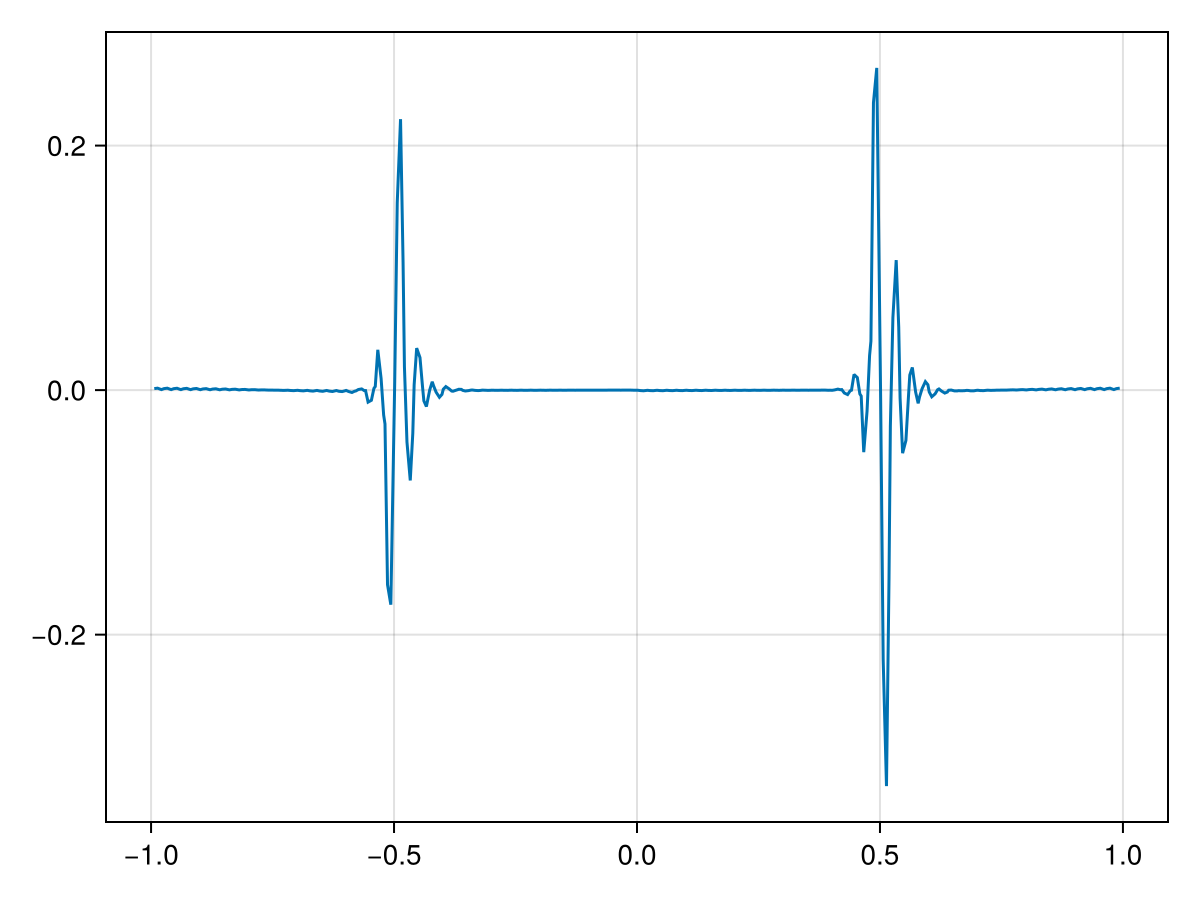

In [203]:
fig = Figure()
ax = Axis(fig[1,1])

# lines!(ax, xgrid, data.xt[:,1])
lines!(ax, xs, PA*data.xt[:,100])

fig

Define ObsConstraintSystem

In [297]:
idx = 4

## Selecion of hyper-prior parameters
# power parameter
r_range = [ 1.0, .5, -.5, -1.0 ]; 
r = r_range[idx] # select parameter 
# shape parameter
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ]; 
β = β_range[idx] # shape parameter
# rate parameters 
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ]; 
ϑ = 1e-2#5e-3#ϑ_range[idx]

r = 1.0
β = 0.5*(Ne + 2) + 1e-3
ϑ = 1e-3

# β = Ne/2


# r = -0.5
# β = 0.5
# ϑ = 0.01
dist = GeneralizedGamma(r, β, ϑ);

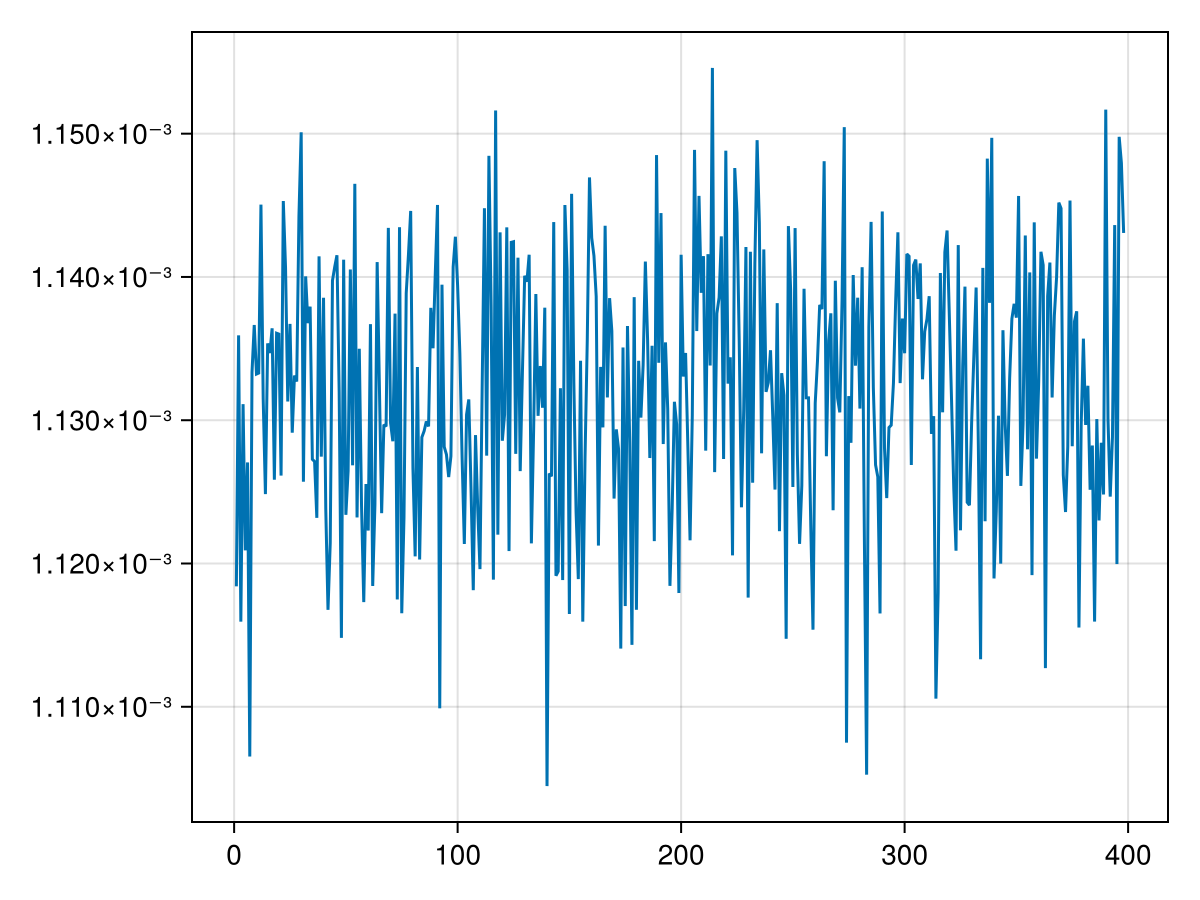

In [298]:
fig = Figure()

lines(rand(dist, Ns))

Create initial ensemble

In [299]:
Ne = 50
X = zeros(model.Ny + model.Nx, Ne)

for i=1:Ne
    regenerate!(f0)
    X[Ny+1:Ny+Nx,i] = f0.(xgrid)#initial_condition(αk, Δx, Nx)
end

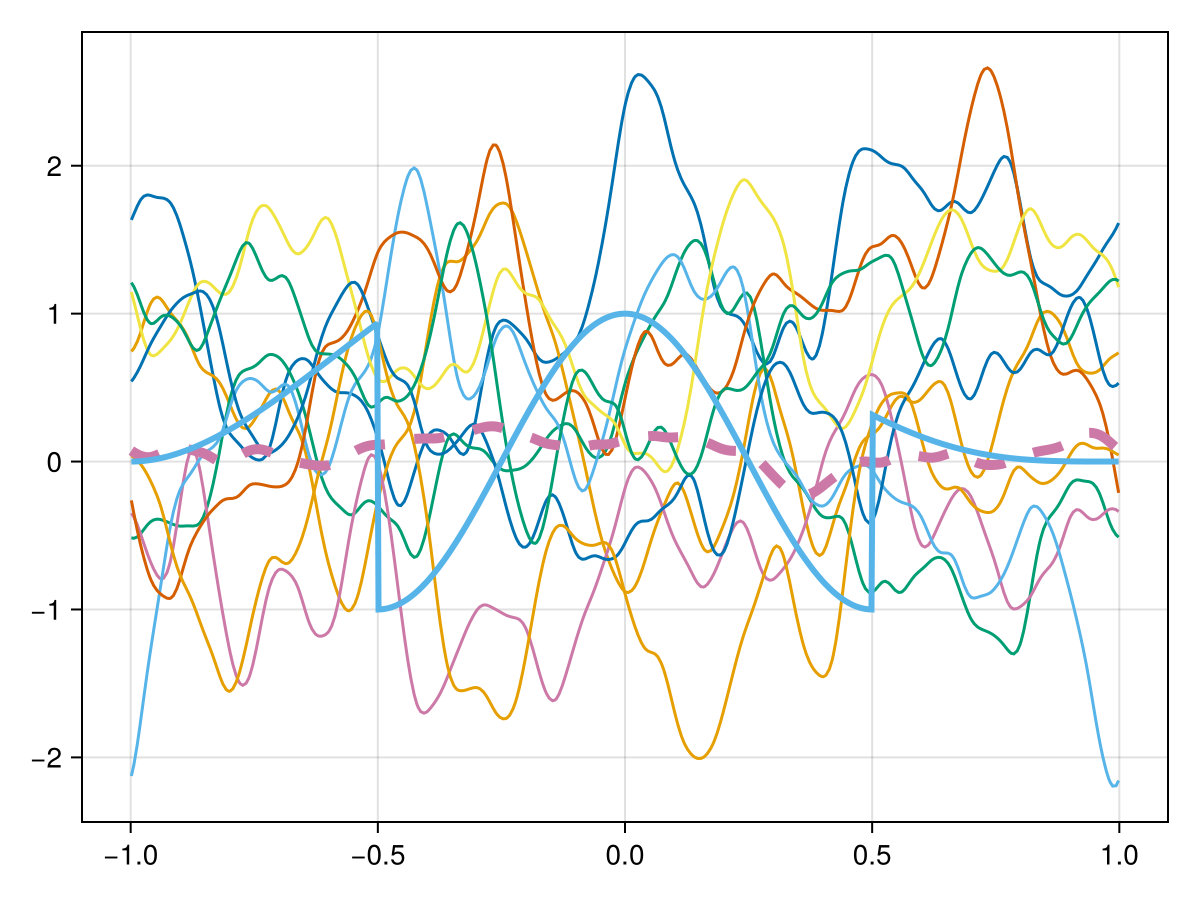

In [300]:
fig = Figure()

ax = Axis(fig[1,1])

for i=1:10
    lines!(ax, xgrid, X[Ny+1:Ny+Nx,i])
end
lines!(xgrid, mean(X[Ny+1:Ny+Nx,:]; dims = 2)[:,1], linewidth = 5, linestyle = :dash)

lines!(ax, xgrid, x0, linewidth = 3)

fig

Define initial guess

In [301]:
θinit = rand(dist, Ns);

Define linear maps and ObsConstraintSystem

In [302]:
Cθ = LinearMap(Diagonal(deepcopy(θinit)))
Cϵ = LinearMap(ϵy.Σ)
CX = LinearMap(Diagonal(1.0 .+ rand(Nx)))
sys_ys = ObsConstraintSystem(H, S, Cθ, Cϵ, CX)

ObsConstraintSystem(400, 20, 398, 20×400 LinearMaps.WrappedMap{Float64} of
  20×400 SparseMatrixCSC{Float64, Int64} with 20 stored entries, 398×400 LinearMaps.FunctionMap{Float64,true}(#131, #132; issymmetric=false, ishermitian=false, isposdef=false), 398×398 LinearMaps.WrappedMap{Float64} of
  398×398 Diagonal{Float64, Vector{Float64}}, 20×20 LinearMaps.WrappedMap{Float64} of
  20×20 Diagonal{Float64, Vector{Float64}}, LinearMap[400×400 LinearMaps.WrappedMap{Float64} of
  400×400 Diagonal{Float64, Vector{Float64}}])

In [303]:
sys_y = ObsSystem(H, Cϵ, CX)

ObsSystem(400, 20, 20×400 LinearMaps.WrappedMap{Float64} of
  20×400 SparseMatrixCSC{Float64, Int64} with 20 stored entries, 20×20 LinearMaps.WrappedMap{Float64} of
  20×20 Diagonal{Float64, Vector{Float64}}, LinearMap[400×400 LinearMaps.WrappedMap{Float64} of
  400×400 Diagonal{Float64, Vector{Float64}}])

In [321]:
yidx = 1:Δ:Nx
idx = vcat(collect(1:length(yidx))', collect(yidx)')

# @assert length(yidx) == Ny

# # Create Localization structure
Gxx(i,j) = periodicmetric!(i,j, Nx)
Gxy(i,j) = periodicmetric!(i,yidx[j], Nx)
Gyy(i,j) = periodicmetric!(yidx[i],yidx[j], Nx)

Lrad = 20
Loc = Localization(Lrad, Gxx, Gxy, Gxx)

Localization(20.0, Gxx, Gxy, Gxx)

In [322]:
β = 1.01
ϵxβ = MultiAddInflation(Nx, β, zeros(Nx), σx)

MultiAddInflation(400, 1.02, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0025000000000000005 0.0 … 0.0 0.0; 0.0 0.0025000000000000005 … 0.0 0.0; … ; 0.0 0.0 … 0.0025000000000000005 0.0; 0.0 0.0 … 0.0 0.0025000000000000005], [0.05 0.0 … 0.0 0.0; 0.0 0.05 … 0.0 0.0; … ; 0.0 0.0 … 0.05 0.0; 0.0 0.0 … 0.0 0.05])

Define EnKF

In [306]:
enkf = EnKF(Ne, ϵy, sys_y, Δtdyn, Δtobs)

Ensemble Kalman filter with 
iterative solver = false and 
filtered = false


Define localized EnKF

In [307]:
locenkf = LocEnKF(Ne, ϵy, sys_y, Loc, Δtdyn, Δtobs)

Localized ensemble Kalman filter with iterative = false and filtered = false


Define hierarchical EnKF

In [308]:
henkf = HEnKF(Ne, ϵy, sys_ys, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical ensemble Kalman filter with
        iterative solver = false and
        filtered = false


Define hierarchical and localized EnKF

In [309]:
hlocenkf = HLocEnKF(Ne, ϵy, sys_ys, Loc, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical localized ensemble Kalman filter with
        iterative solver = false and
        filtered = false


In [310]:
# X_enkf = seqassim_trixi(data, Tf, ϵxβ, enkf, deepcopy(X), model.Ny, model.Nx, t0, sys_lin);

In [311]:
X_locenkf = seqassim_trixi(data, Tf, ϵxβ, locenkf, deepcopy(X), model.Ny, model.Nx, t0, sys_lin);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


In [312]:
# X_henkf, θ_henkf = seqassim_trixi(data, Tf, ϵxβ, henkf, deepcopy(X), model.Ny, model.Nx, t0, sys_lin);

In [323]:
X_hlocenkf, θ_hlocenkf = seqassim_trixi(data, Tf, ϵxβ, hlocenkf, deepcopy(X), model.Ny, model.Nx, t0, sys_lin);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:12


In [324]:
rmse_locenkf = mean(map(i->norm(data.xt[:,i]-mean(X_locenkf[i+1]; dims = 2))/sqrt(Nx), Tspin:Tf))

0.10350713363792635

In [325]:
spread_locenkf = mean(map(i->spread(X_locenkf[i+1]), Tspin:Tf))

0.16178141288156606

In [326]:
crps_locenkf = mean(map(i->mean(map(k->CRPS(X_locenkf[i+1][k,:], data.xt[k,i]), 1:Nx)), Tspin:Tf))

0.06289733404135715

In [327]:
rmse_hlocenkf = mean(map(i->norm(data.xt[:,i]-mean(X_hlocenkf[i+1]; dims = 2))/sqrt(Nx), Tspin:Tf))

0.18649108583256688

In [328]:
spread_hlocenkf = mean(map(i->spread(X_hlocenkf[i+1]), Tspin:Tf))

0.012375570569427716

In [329]:
crps_hlocenkf = mean(map(i->mean(map(k->CRPS(X_hlocenkf[i+1][k,:], data.xt[k,i]), 1:Nx)), Tspin:Tf))

0.1223686002234302

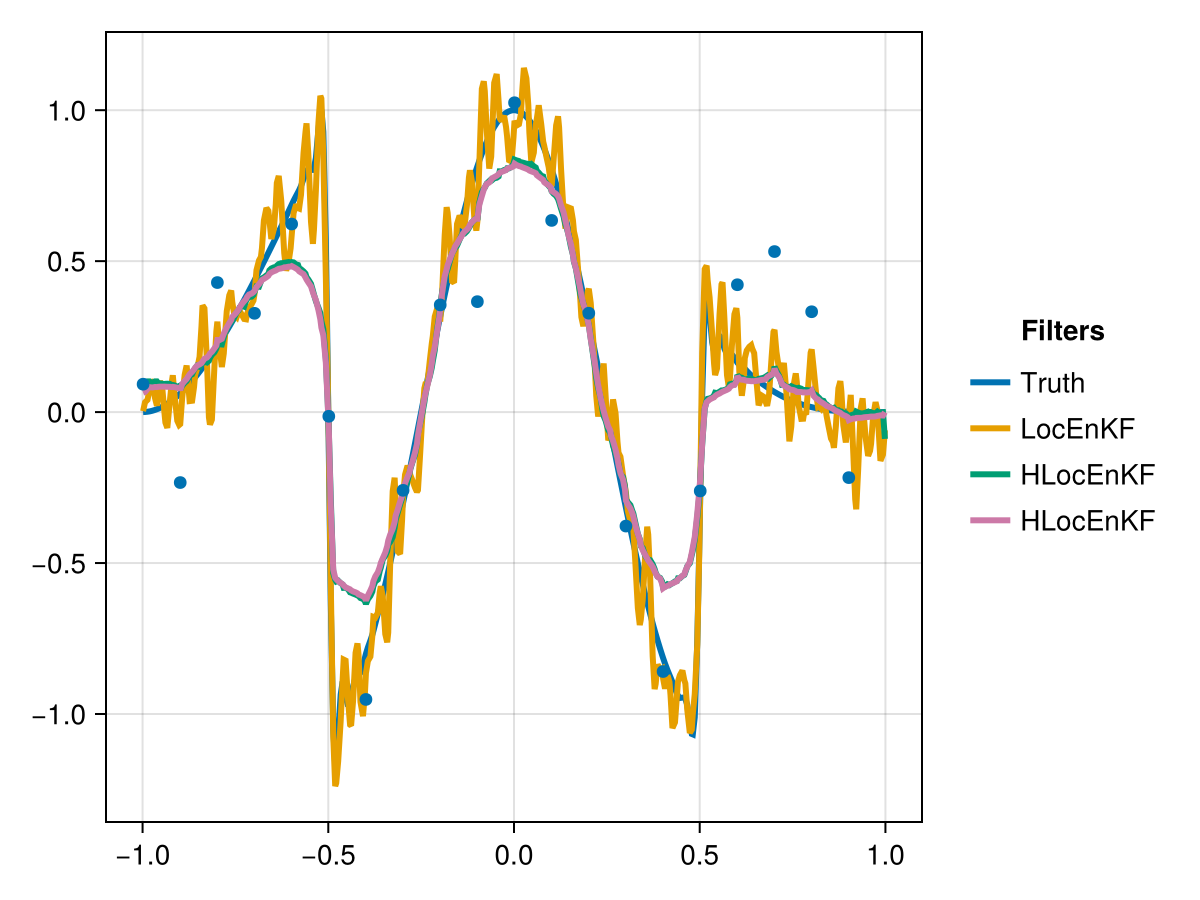

In [320]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 200
idx = 10

lines!(ax, xgrid, data.xt[:,tsnap], linewidth = 3, label = "Truth")

# lines!(ax, xgrid, X[Ny+1:Ny+Nx,2])
# lines!(ax, xgrid, X_enkf[tsnap+1][:,idx], linewidth = 3, label = "EnKF")
# lines!(ax, xgrid, mean(X_enkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "EnKF")

# lines!(ax, xgrid, X_locenkf[tsnap+1][:,idx], linewidth = 3, label = "LocEnKF")
lines!(ax, xgrid, mean(X_locenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "LocEnKF")


# lines!(ax, xgrid, X_henkf[tsnap+1][:,2], linewidth = 3, label = "HEnKF")
# lines!(ax, xgrid, X_henkf[tsnap+1][:,2])
# lines!(ax, xgrid, mean(X_henkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HEnKF")

lines!(ax, xgrid, X_hlocenkf[tsnap+1][:,idx], linewidth = 3, label = "HLocEnKF")
lines!(ax, xgrid, mean(X_hlocenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HLocEnKF")

# ax2 = Axis(fig[1,2])

fig[1, 2] = Legend(fig, ax, "Filters", framevisible = false)

# lines!(ax, xgrid[1:2:end], data.yt[:,tsnap], linewidth = 3)


scatter!(ax, xgrid[1:Δ:end], data.yt[:,tsnap])
# lines!(ax, xs, PA.P*X_enkf[tsnap+1][:,2])


fig

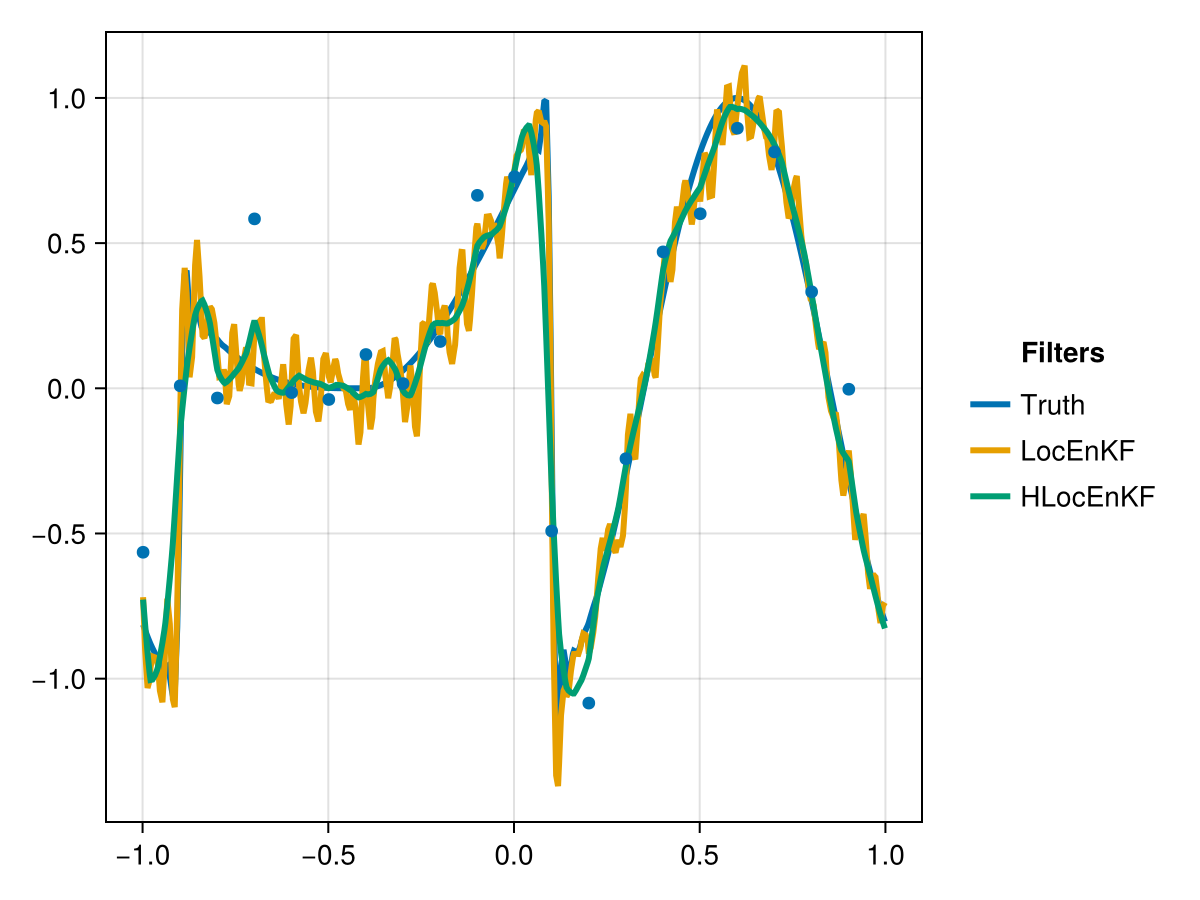

In [230]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 60
idx = 10

lines!(ax, xgrid, data.xt[:,tsnap], linewidth = 3, label = "Truth")

# lines!(ax, xgrid, X[Ny+1:Ny+Nx,2])
# lines!(ax, xgrid, X_enkf[tsnap+1][:,idx], linewidth = 3, label = "EnKF")
# lines!(ax, xgrid, mean(X_enkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "EnKF")

# lines!(ax, xgrid, X_locenkf[tsnap+1][:,idx], linewidth = 3, label = "LocEnKF")
lines!(ax, xgrid, mean(X_locenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "LocEnKF")


# lines!(ax, xgrid, X_henkf[tsnap+1][:,2], linewidth = 3, label = "HEnKF")
# lines!(ax, xgrid, X_henkf[tsnap+1][:,2])
# lines!(ax, xgrid, mean(X_henkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HEnKF")

# lines!(ax, xgrid, X_hlocenkf[tsnap+1][:,idx], linewidth = 3, label = "HLocEnKF")
lines!(ax, xgrid, mean(X_hlocenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HLocEnKF")

# ax2 = Axis(fig[1,2])

fig[1, 2] = Legend(fig, ax, "Filters", framevisible = false)

# lines!(ax, xgrid[1:2:end], data.yt[:,tsnap], linewidth = 3)


scatter!(ax, xgrid[1:Δ:end], data.yt[:,tsnap])
# lines!(ax, xs, PA.P*X_enkf[tsnap+1][:,2])


fig

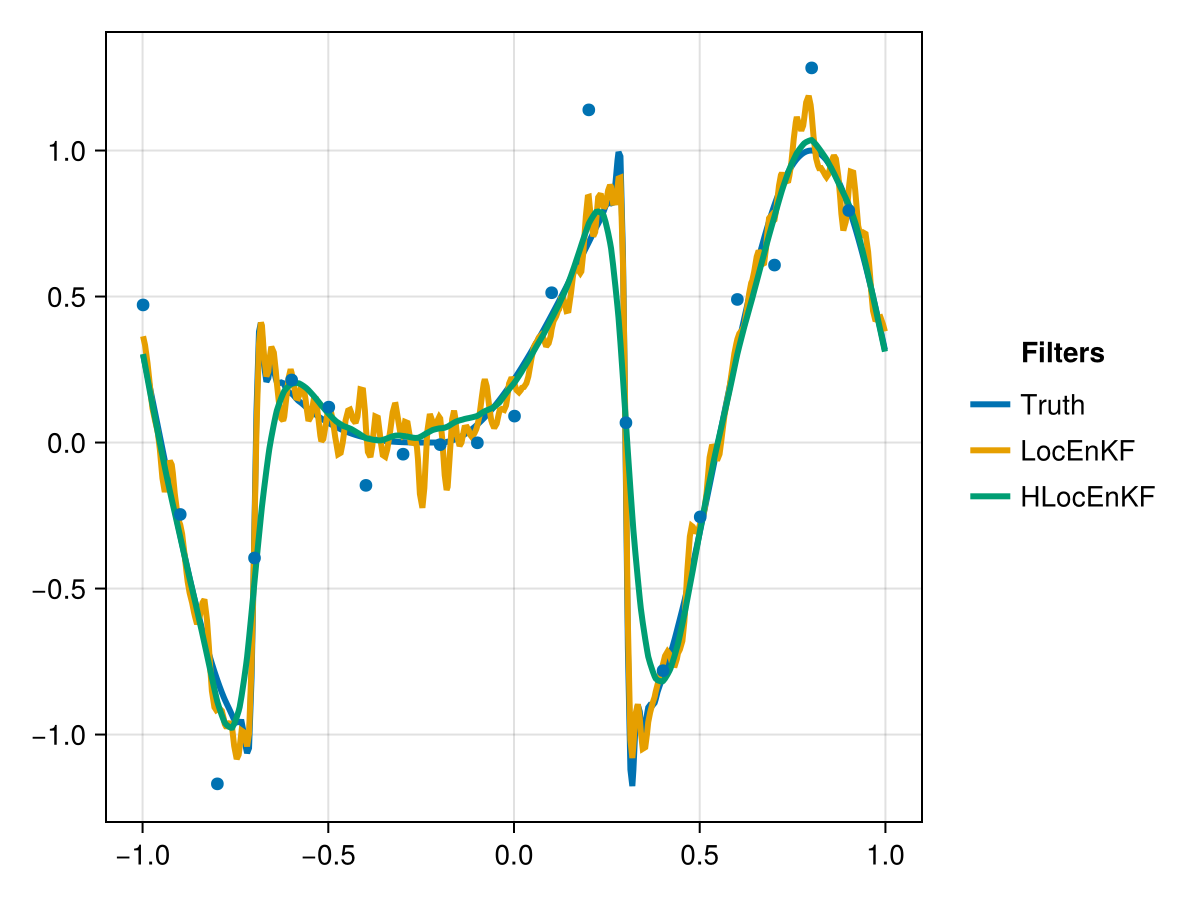

In [137]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 160
idx = 10

lines!(ax, xgrid, data.xt[:,tsnap], linewidth = 3, label = "Truth")

# lines!(ax, xgrid, X[Ny+1:Ny+Nx,2])
# lines!(ax, xgrid, X_enkf[tsnap+1][:,idx], linewidth = 3, label = "EnKF")
# lines!(ax, xgrid, mean(X_enkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "EnKF")

# lines!(ax, xgrid, X_locenkf[tsnap+1][:,idx], linewidth = 3, label = "LocEnKF")
lines!(ax, xgrid, mean(X_locenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "LocEnKF")


# lines!(ax, xgrid, X_henkf[tsnap+1][:,2], linewidth = 3, label = "HEnKF")
# lines!(ax, xgrid, X_henkf[tsnap+1][:,2])
# lines!(ax, xgrid, mean(X_henkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HEnKF")

# lines!(ax, xgrid, X_hlocenkf[tsnap+1][:,idx], linewidth = 3, label = "HLocEnKF")
lines!(ax, xgrid, mean(X_hlocenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HLocEnKF")

# ax2 = Axis(fig[1,2])

fig[1, 2] = Legend(fig, ax, "Filters", framevisible = false)

# lines!(ax, xgrid[1:2:end], data.yt[:,tsnap], linewidth = 3)


scatter!(ax, xgrid[1:Δ:end], data.yt[:,tsnap])
# lines!(ax, xs, PA.P*X_enkf[tsnap+1][:,2])


fig

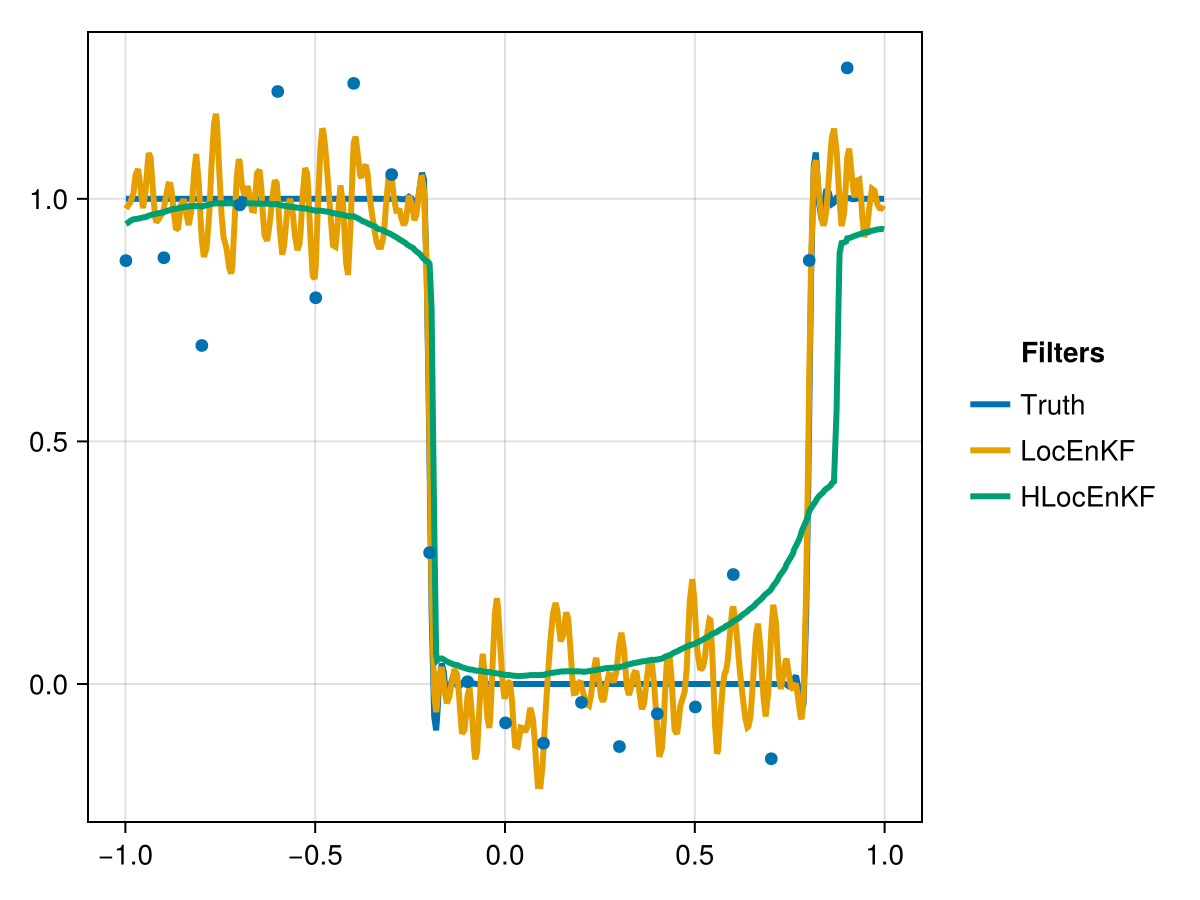

In [84]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 80
idx = 10

lines!(ax, xgrid, data.xt[:,tsnap], linewidth = 3, label = "Truth")

# lines!(ax, xgrid, X[Ny+1:Ny+Nx,2])
# lines!(ax, xgrid, X_enkf[tsnap+1][:,idx], linewidth = 3, label = "EnKF")
# lines!(ax, xgrid, mean(X_enkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "EnKF")

# lines!(ax, xgrid, X_locenkf[tsnap+1][:,idx], linewidth = 3, label = "LocEnKF")
lines!(ax, xgrid, mean(X_locenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "LocEnKF")


# lines!(ax, xgrid, X_henkf[tsnap+1][:,2], linewidth = 3, label = "HEnKF")
# lines!(ax, xgrid, X_henkf[tsnap+1][:,2])
# lines!(ax, xgrid, mean(X_henkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HEnKF")

# lines!(ax, xgrid, X_hlocenkf[tsnap+1][:,idx], linewidth = 3, label = "HLocEnKF")
lines!(ax, xgrid, mean(X_hlocenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HLocEnKF")

# ax2 = Axis(fig[1,2])

fig[1, 2] = Legend(fig, ax, "Filters", framevisible = false)

# lines!(ax, xgrid[1:2:end], data.yt[:,tsnap], linewidth = 3)


scatter!(ax, xgrid[1:Δ:end], data.yt[:,tsnap])
# lines!(ax, xs, PA.P*X_enkf[tsnap+1][:,2])


fig

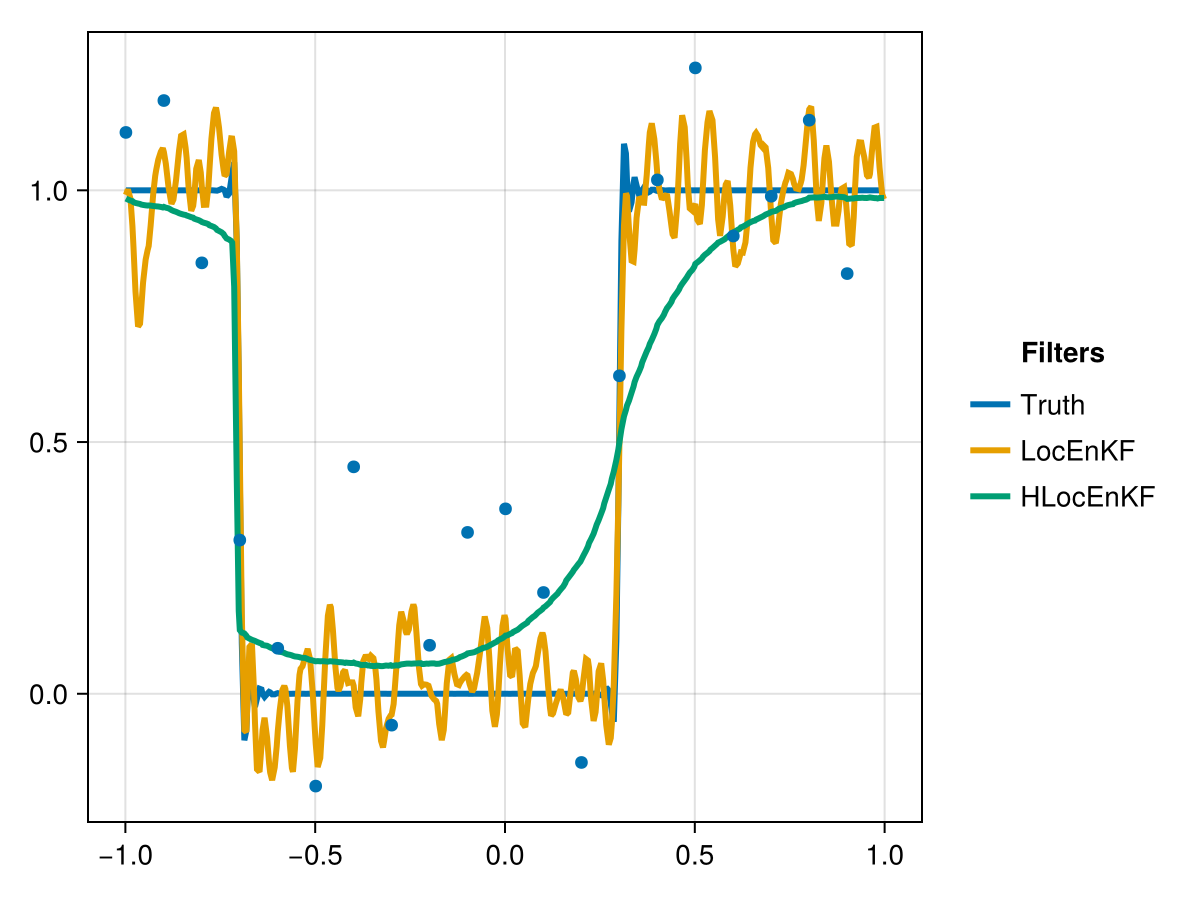

In [76]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 30
idx = 10

lines!(ax, xgrid, data.xt[:,tsnap], linewidth = 3, label = "Truth")

# lines!(ax, xgrid, X[Ny+1:Ny+Nx,2])
# lines!(ax, xgrid, X_enkf[tsnap+1][:,idx], linewidth = 3, label = "EnKF")
# lines!(ax, xgrid, mean(X_enkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "EnKF")

# lines!(ax, xgrid, X_locenkf[tsnap+1][:,idx], linewidth = 3, label = "LocEnKF")
lines!(ax, xgrid, mean(X_locenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "LocEnKF")


# lines!(ax, xgrid, X_henkf[tsnap+1][:,2], linewidth = 3, label = "HEnKF")
# lines!(ax, xgrid, X_henkf[tsnap+1][:,2])
# lines!(ax, xgrid, mean(X_henkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HEnKF")

# lines!(ax, xgrid, X_hlocenkf[tsnap+1][:,idx], linewidth = 3, label = "HLocEnKF")
lines!(ax, xgrid, mean(X_hlocenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HLocEnKF")

# ax2 = Axis(fig[1,2])

fig[1, 2] = Legend(fig, ax, "Filters", framevisible = false)

# lines!(ax, xgrid[1:2:end], data.yt[:,tsnap], linewidth = 3)


scatter!(ax, xgrid[1:Δ:end], data.yt[:,tsnap])
# lines!(ax, xs, PA.P*X_enkf[tsnap+1][:,2])


fig

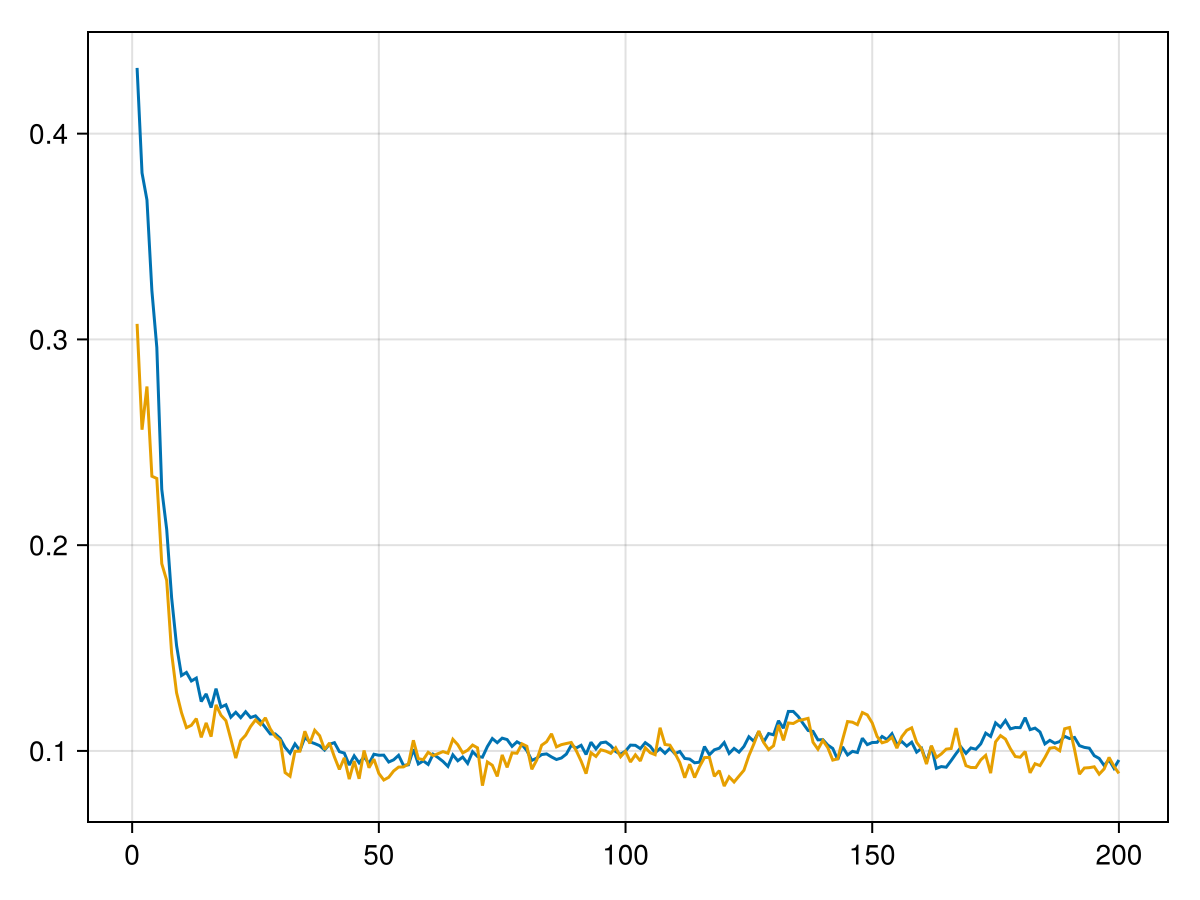

In [263]:
fig = Figure()

ax = Axis(fig[1,1])

lines!(ax, map(i->norm(data.xt[:,i]-mean(X_locenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))
lines!(ax, map(i->norm(data.xt[:,i]-mean(X_hlocenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))
        
fig

In [90]:
tsnap = Observable(1)

x_tsnap = @lift(hcat(data.x0, data.xt)[:,$(tsnap)])
y_tsnap = @lift(hcat(zeros(Ny), data.yt)[:,$(tsnap)])
X_locenkf_tsnap = @lift(mean(X_locenkf[$tsnap]; dims = 2)[:,1])
X_hlocenkf_tsnap = @lift(mean(X_hlocenkf[$tsnap]; dims = 2)[:,1])

scaled_θ_hlocenkf_tsnap = @lift(θ_hlocenkf[$tsnap] / norm(θ_hlocenkf[$tsnap]))


fig = Figure()

ax1 = Axis(fig[1,1])

lines!(ax1, xgrid, x_tsnap, linewidth = 3, label = "Truth")
lines!(ax1, xgrid, X_locenkf_tsnap, linewidth = 3, label = "LocEnKF")
lines!(ax1, xgrid, X_hlocenkf_tsnap, linewidth = 3, label = "HLocEnKF", linestyle =:dashdot)
scatter!(ax1, xgrid[1:Δ:end], y_tsnap, color = :grey)

axislegend(ax1)

ax2 = Axis(fig[1,2])

lines!(ax2, xs, scaled_θ_hlocenkf_tsnap, linewidth = 3, label = L"θ")
ylims!(ax2, 0.0, 0.1)

framerate = 10
timestamps = range(1, 101, step = 1)

record(fig, "linear_advection.mp4", timestamps; framerate = framerate) do t
    tsnap[] = t
end

"linear_advection.mp4"

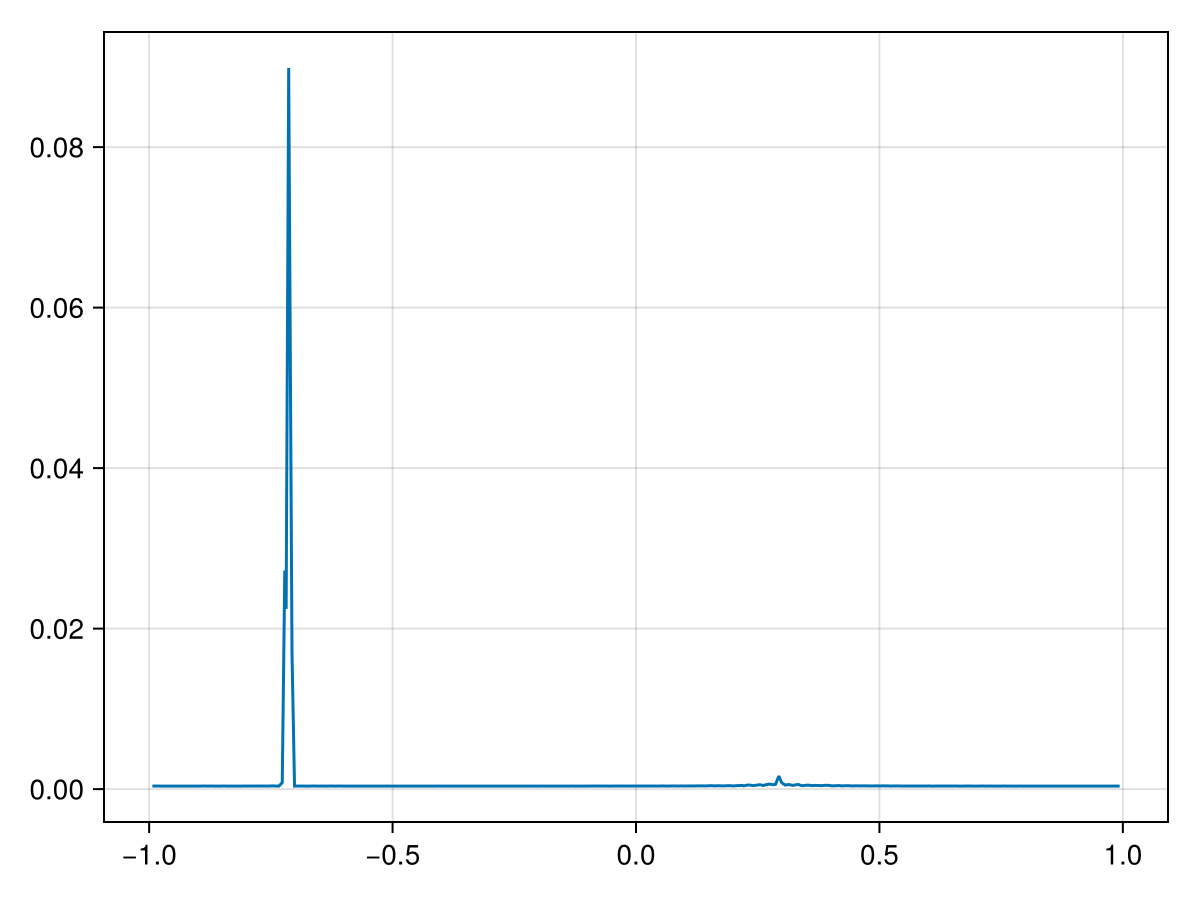

In [77]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 30

# lines!(ax, xs, θ_henkf[tsnap])
lines!(ax, xs, θ_hlocenkf[tsnap])


fig